In [5]:
from sdm.config import get_db_connection
from text_mining.data import get_research_dataframe, load_excel_annotations
from text_mining.utils import train_classifier, preprocess_tweets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
db = get_db_connection(db_path="../../../../data/twitter.db")
df = get_research_dataframe(db)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26019 entries, 0 to 26018
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   account_id    26019 non-null  object
 1   tweet_text    26019 non-null  object
 2   account_type  26019 non-null  object
 3   lang          26019 non-null  object
 4   stance        25480 non-null  object
dtypes: object(5)
memory usage: 1016.5+ KB
None


,account_id,tweet_text,account_type,lang,stance
0,77254498,"""@ComposerCorner I am proud to be a #climatech...",Private individuals,en,For
1,77254498,#ActionDay ~ Blog ~ Greener Green Gifts ~ htt...,Private individuals,en,For
2,77254498,#Agnotology ~ @Ecojustice files complaint w/Co...,Private individuals,en,For
3,77254498,#AsPredicted ~ @Canada wins #FossiloftheDay ~ ...,Private individuals,en,For
4,77254498,#AusPol ~ #COP21 ~ #MentalHealth of #Australia...,Private individuals,en,For


## Hypothesis: Private Individuals will use more negative sentiment than Business Actors

Private indivduals (we believe) tend to have less PR overhead compared to businesses entities/accounts. They are more likely to use tweet negative things since they are not bound by coporate restrictions or public image concerns. As a result, private individuals often feel more freedom to express their opinions, including criticism or controversial statements, without worrying about the impact on a brand or company reputation. In contrast, businesses typically have to carefully manage their public relations to maintain customer trust and uphold their corporate identity, which can lead them to be more cautious or restrained in their communications.

Long story short, individuals can be trolls and businesses typically aren't (unless we are talkin' Alex Jones et al. etc.)

In [7]:
df_train = load_excel_annotations("../../../../data/train.xlsx")
df_train["train"] = True
df_test = load_excel_annotations("../../../../data/test.xlsx")
df_test["train"] = False

df_train = pd.concat([df_train, df_test])
subset_nas = ["CODE", "TEXT"]
df_train = df_train.dropna(subset=subset_nas, ignore_index=True)

In [17]:
cls_final, vectorizer = train_classifier(df_train["TEXT"].tolist(), labels=df_train["CODE"], test_size=0.02)
processed_data = ml_annotations = cls_final.predict(vectorizer.transform(preprocess_tweets(df["tweet_text"])))
df["sentiment"] = ml_annotations

Classification Rep:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [16]:
df[["account_type", "sentiment", "tweet_text"]].sample(10)

,account_type,sentiment,tweet_text
11591,Private individuals,0.0,#COP21: Sassou N'Guesso a plaidé Congo et l’A...
9020,Business actors,1.0,Make the change - sign #ifad petition @ https:...
25449,Business actors,1.0,RT @RoadThruParis: We're doing daily media cov...
17497,Private individuals,0.0,.#OpChemtrails https://t.co/sdyIyQVW0O #OpChem...
15084,Private individuals,1.0,RT @SaleemulHuq: US Secretary of State John Ke...
7050,Private individuals,0.0,RT @Starbuck: In final hours thoughts turn to ...
7126,Private individuals,1.0,"RT @este_tapias: ""The false myth: economic dev..."
671,Private individuals,1.0,"Fresh blog ~ Dear Elizabeth May, ~ https://t.c..."
6564,Business actors,1.0,The Govt's about to slap 20% VAT on solar pane...
24152,Business actors,-1.0,".@EdwardJCameron: ""A whole new global economy ..."


In [18]:
summary_stats = df.groupby("account_type")["sentiment"].describe()
print(summary_stats)

                       count      mean       std  min  25%  50%  75%  max
account_type                                                             
Business actors       9156.0  0.654325  0.506316 -1.0  0.0  1.0  1.0  1.0
Private individuals  16863.0  0.577062  0.523983 -1.0  0.0  1.0  1.0  1.0


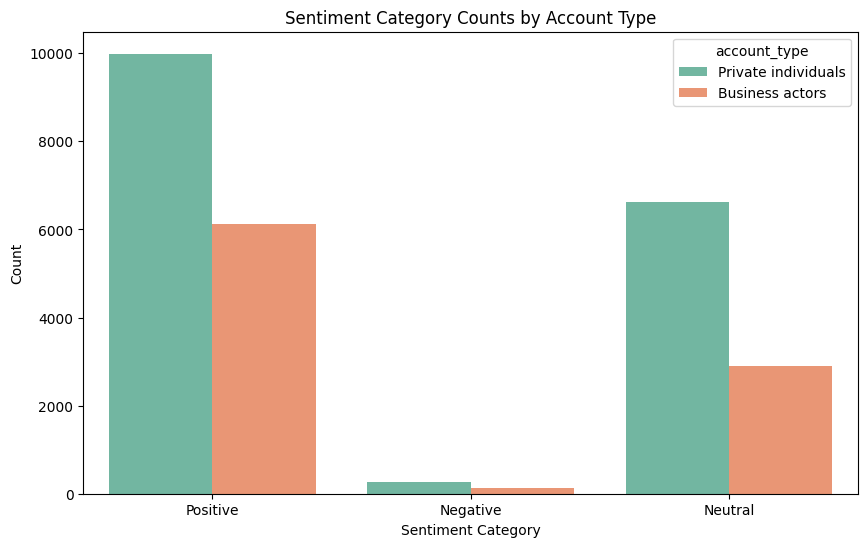

In [22]:
df['sentiment_category'] = df['sentiment'].map({-1.0: 'Negative', 0.0: 'Neutral', 1.0: 'Positive'})

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment_category', hue='account_type', palette="Set2")
plt.title("Sentiment Category Counts by Account Type")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.show()

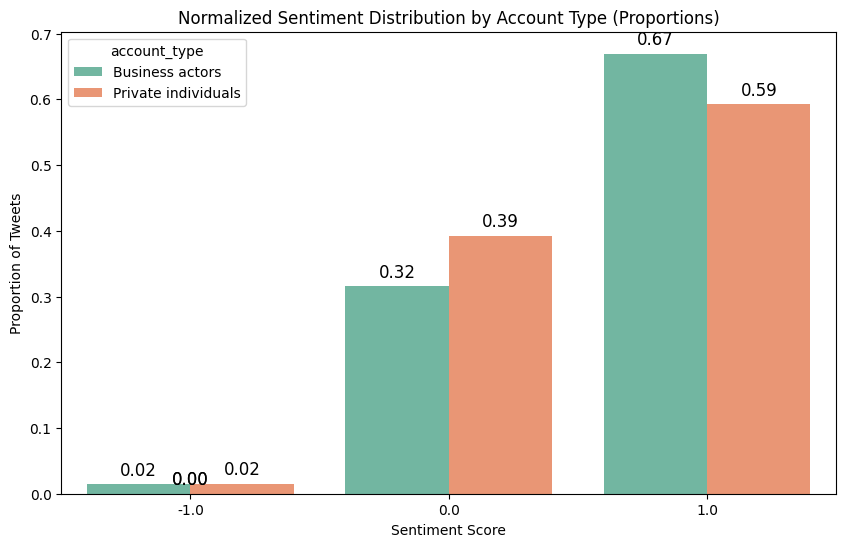

In [25]:
sentiment_proportions = df.groupby(['account_type', 'sentiment']).size().unstack(fill_value=0)
sentiment_proportions = sentiment_proportions.div(sentiment_proportions.sum(axis=1), axis=0)  # Normalize to proportions
sentiment_proportions = sentiment_proportions.reset_index().melt(id_vars="account_type", value_name="proportion")
plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_proportions, x="sentiment", y="proportion", hue="account_type", palette="Set2")
plt.title("Normalized Sentiment Distribution by Account Type (Proportions)")
plt.xlabel("Sentiment Score")
plt.ylabel("Proportion of Tweets")

for p in plt.gca().patches:
    plt.gca().annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', fontsize=12, color='black', 
        xytext=(0, 10), textcoords='offset points'
    )

# Show the plot
plt.show()

### Running simple t-test against null hypo that mean sentiments are equal

In [27]:
from scipy import stats

private_sentiment = df[df['account_type'] == 'Private individuals']['sentiment']
business_sentiment = df[df['account_type'] == 'Business actors']['sentiment']

t_stat, p_value = stats.ttest_ind(private_sentiment, business_sentiment, equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -11.61087107496186
P-value: 4.600591442576968e-31


In [32]:
# love me some bootstrapping
private_bootstrap = np.random.choice(private_sentiment, (10_000, len(private_sentiment)), replace=True)
private_means = private_bootstrap.mean(axis=1)
private_ci = np.percentile(private_means, [2.5, 97.5])

business_bootstrap = np.random.choice(business_sentiment, (10_000, len(business_sentiment)), replace=True)
business_means = business_bootstrap.mean(axis=1)
business_ci = np.percentile(business_means, [2.5, 97.5])

print(f"Private Individuals:")
print(f"  Mean: {private_sentiment.mean():.3f}")
print(f"  95% Confidence Interval: ({private_ci[0]:.3f}, {private_ci[1]:.3f})")

print(f"\nBusiness Actors:")
print(f"  Mean: {business_sentiment.mean():.3f}")
print(f"  95% Confidence Interval: ({business_ci[0]:.3f}, {business_ci[1]:.3f})")

Private Individuals:
  Mean: 0.577
  95% Confidence Interval: (0.569, 0.585)

Business Actors:
  Mean: 0.654
  95% Confidence Interval: (0.644, 0.665)


## Conclusion: Our hypothesis was correct
Business actors have a higher sentiment that private individuals